# Baseline Model - Derm7pt-skin lesion classification
**Author:** Anam Ayyub  
**Purpose:** Load dataset, preprocess, train baseline models (Logistic Regression, kNN, Naïve Bayes, Decision Tree), evaluate models using metrics, and visualize results.
===================================================


In [11]:
# ======================================================
# 1. Imports
# ======================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

sns.set(style="whitegrid", context="notebook")
pd.set_option("display.max_columns", 100)



In [12]:
# ======================================================
# 2. Load Cleaned Dataset
# ======================================================
DATASET_PATH = r"C:\Users\anama\Documents\Group_8\Dataset\DERM7PT"

X = pd.read_csv(os.path.join(DATASET_PATH, "meta", "features.csv"))
y_binary = pd.read_csv(os.path.join(DATASET_PATH, "meta", "target_binary.csv"))
y_multiclass = pd.read_csv(os.path.join(DATASET_PATH, "meta", "target_multiclass.csv"))

train_idx = pd.read_csv(os.path.join(DATASET_PATH, "meta", "train_indexes.csv"))["indexes"].tolist()
valid_idx = pd.read_csv(os.path.join(DATASET_PATH, "meta", "valid_indexes.csv"))["indexes"].tolist()
test_idx  = pd.read_csv(os.path.join(DATASET_PATH, "meta", "test_indexes.csv"))["indexes"].tolist()

X_train, X_valid, X_test = X.iloc[train_idx], X.iloc[valid_idx], X.iloc[test_idx]
y_train_bin, y_valid_bin, y_test_bin = y_binary.iloc[train_idx], y_binary.iloc[valid_idx], y_binary.iloc[test_idx]
y_train_multi, y_valid_multi, y_test_multi = y_multiclass.iloc[train_idx], y_multiclass.iloc[valid_idx], y_multiclass.iloc[test_idx]

# Flatten binary targets
y_train_bin = y_train_bin.values.ravel()
y_valid_bin = y_valid_bin.values.ravel()
y_test_bin  = y_test_bin.values.ravel()

print("Data loaded successfully.")
print("Feature shapes:", X_train.shape, X_valid.shape, X_test.shape)
print("Binary target distribution (train):")
display(pd.Series(y_train_bin).value_counts())


Data loaded successfully.
Feature shapes: (413, 16) (203, 16) (395, 16)
Binary target distribution (train):


0    323
1     90
Name: count, dtype: int64

In [13]:
# ======================================================
# 3. Metrics Functions
# ======================================================
def print_metrics(y_true, y_pred, split_name):
    print(f"\n{split_name} Metrics:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1 Score :", f1_score(y_true, y_pred, zero_division=0))

def get_metrics(y_true, y_pred, y_prob=None):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)
    }
    metrics["AUC"] = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    return metrics


In [15]:
# ======================================================
# 4. Encode categorical features (convert to numeric)
# ======================================================

# Identify categorical columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns:", cat_cols)

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Recreate train/valid/test splits with encoded data
X_train = X_encoded.iloc[train_idx]
X_valid = X_encoded.iloc[valid_idx]
X_test  = X_encoded.iloc[test_idx]

print("Encoded feature shape:", X_encoded.shape)


Categorical columns: ['pigment_network', 'streaks', 'pigmentation', 'regression_structures', 'dots_and_globules', 'blue_whitish_veil', 'vascular_structures', 'level_of_diagnostic_difficulty', 'elevation', 'location', 'sex', 'management', 'clinic', 'derm']
Encoded feature shape: (1011, 2058)



Test Metrics:
Accuracy : 0.9012658227848102
Precision: 0.7421875
Recall   : 0.9405940594059405
F1 Score : 0.8296943231441049


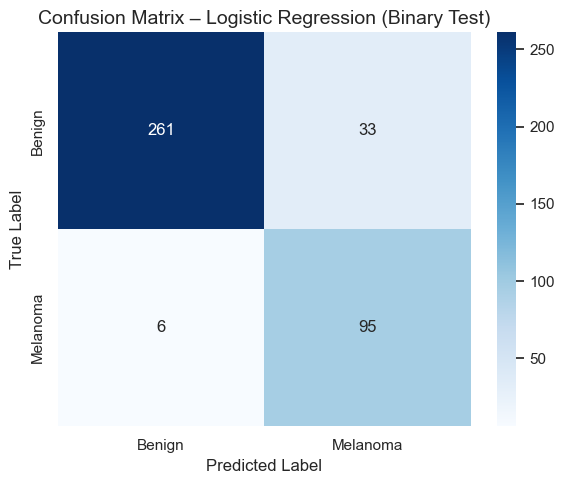

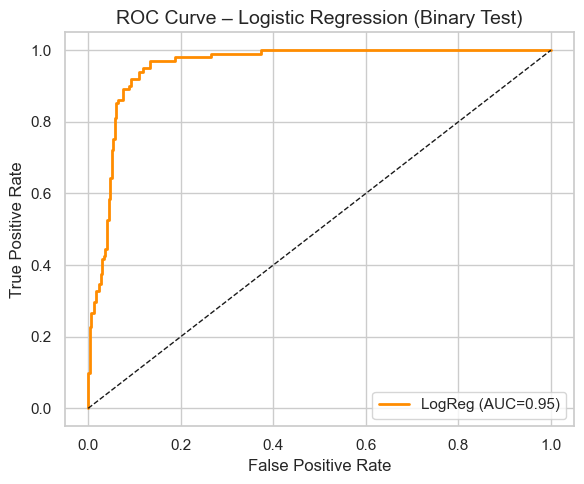

In [16]:
# ======================================================
# 5. Logistic Regression (Binary)
# ======================================================
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train_bin)

y_pred_test = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:,1]

print_metrics(y_test_bin, y_pred_test, "Test")

# Confusion Matrix
cm = confusion_matrix(y_test_bin, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign","Melanoma"], yticklabels=["Benign","Melanoma"])
plt.title("Confusion Matrix – Logistic Regression (Binary Test)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin, y_prob_lr)
auc = roc_auc_score(y_test_bin, y_prob_lr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LogReg (AUC={auc:.2f})", color="darkorange", lw=2)
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve – Logistic Regression (Binary Test)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()



Test Metrics:
Accuracy : 0.8911392405063291
Precision: 0.8085106382978723
Recall   : 0.7524752475247525
F1 Score : 0.7794871794871795


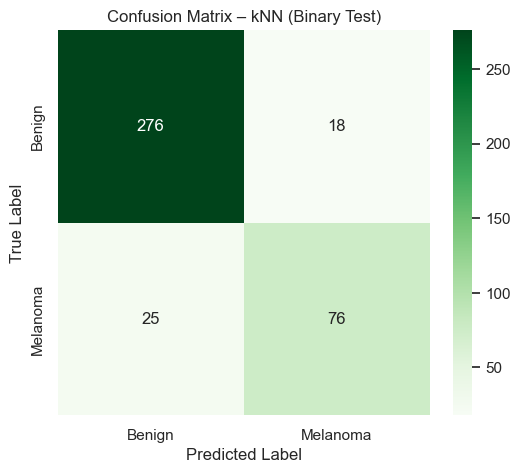

In [17]:
# ======================================================
# 6. kNN (Binary)
# ======================================================
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
knn.fit(X_train, y_train_bin)

y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:,1]

print_metrics(y_test_bin, y_pred_knn, "Test")

cm = confusion_matrix(y_test_bin, y_pred_knn)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Benign","Melanoma"], yticklabels=["Benign","Melanoma"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – kNN (Binary Test)")
plt.show()



Test Metrics:
Accuracy : 0.7139240506329114
Precision: 0.4714285714285714
Recall   : 0.9801980198019802
F1 Score : 0.6366559485530546


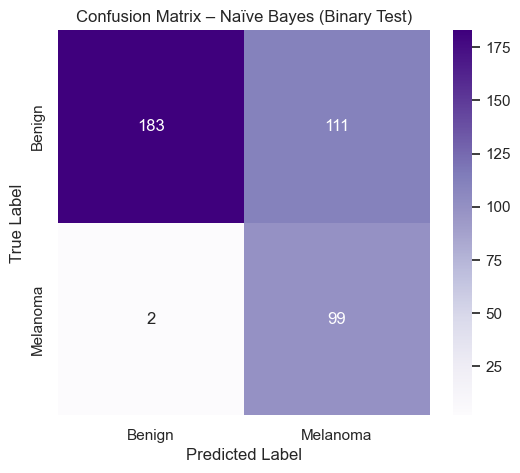

In [18]:
# ======================================================
# 7. Gaussian Naïve Bayes (Binary)
# ======================================================
nb = GaussianNB()
nb.fit(X_train, y_train_bin)

y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:,1]

print_metrics(y_test_bin, y_pred_nb, "Test")

cm = confusion_matrix(y_test_bin, y_pred_nb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Benign","Melanoma"], yticklabels=["Benign","Melanoma"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Naïve Bayes (Binary Test)")
plt.show()



Naïve Bayes (Multiclass) Report:
              precision    recall  f1-score   support

           0       0.47      0.44      0.45        16
           1       0.21      0.82      0.34        11
           2       0.78      0.04      0.08       156
           3       0.00      0.00      0.00         5
           4       0.13      0.50      0.21         4
           5       0.16      0.62      0.26         8
           6       0.33      0.29      0.31         7
           7       0.64      0.58      0.61        12
           8       0.00      0.00      0.00         1
           9       0.23      0.50      0.32        18
          10       0.26      0.81      0.39        26
          11       0.00      0.00      0.00        40
          12       0.12      0.20      0.15        15
          13       0.00      0.00      0.00         1
          14       0.75      0.50      0.60         6
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00    

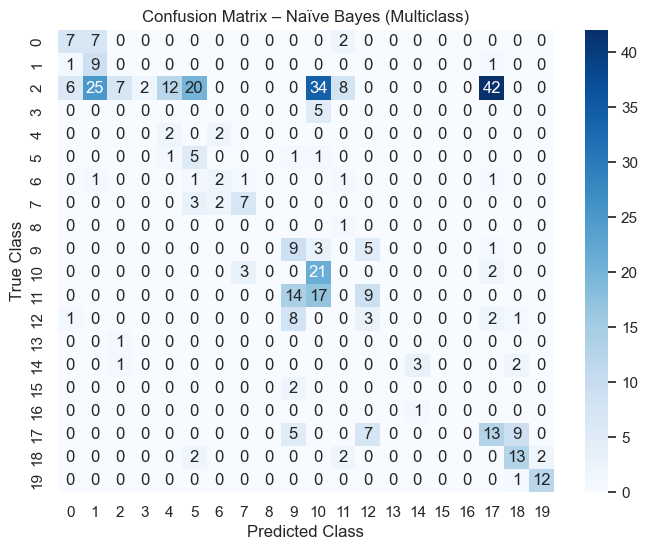

In [19]:
# ======================================================
# 8. Gaussian Naïve Bayes (Multiclass)
# ======================================================
nb_multi = GaussianNB()
nb_multi.fit(X_train, y_train_multi.values.argmax(axis=1))

y_pred_nb_multi = nb_multi.predict(X_test)

print("\nNaïve Bayes (Multiclass) Report:")
print(classification_report(y_test_multi.values.argmax(axis=1), y_pred_nb_multi, zero_division=0))

cm = confusion_matrix(y_test_multi.values.argmax(axis=1), y_pred_nb_multi)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix – Naïve Bayes (Multiclass)")
plt.show()


In [21]:
# ======================================================
# 9. Aggregate Model Metrics
# ======================================================
results = {}
results["Logistic Regression"] = get_metrics(y_test_bin, y_pred_test, y_prob_lr)
results["kNN (k=5)"] = get_metrics(y_test_bin, y_pred_knn, y_prob_knn)
results["Naïve Bayes"] = get_metrics(y_test_bin, y_pred_nb, y_prob_nb)
# results["Decision Tree"] = get_metrics(y_test_bin, y_pred_dt_bin, y_prob_dt_bin)  # Optional

results_df = pd.DataFrame(results).T
results_df.index.name = "Model"

print("\nBaseline Model Performance Comparison (Binary Classification):")
display(results_df)



Baseline Model Performance Comparison (Binary Classification):


,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Logistic Regression,0.901266,0.742188,0.940594,0.829694,0.954907
kNN (k=5),0.891139,0.808511,0.752475,0.779487,0.941419
Naïve Bayes,0.713924,0.471429,0.980198,0.636656,0.801323


## Executive Summary – (Baseline Models)

- **Objective:**  
  Establish baseline performance for metadata‑only classification before extending to image‑based CNNs and multimodal fusion.  

- **Targets:**  
  - **Binary:** melanoma vs. benign (primary research focus)  
  - **Multiclass:** full diagnosis categories (secondary)  

- **Approach:**  
  - Loaded cleaned features and targets from Lab 2 (`features.csv`, `target_binary.csv`, `target_multiclass.csv`)  
  - Applied provided train/valid/test splits to ensure reproducibility  
  - Trained baseline models: **Logistic Regression, Decision Tree, k‑Nearest Neighbors (k=5), and Naïve Bayes**  
  - Evaluated models using **accuracy, precision, recall, F1‑score, ROC curves, AUC**, and confusion matrices  
  - Extended Naïve Bayes to the **multiclass setting** to benchmark performance across all diagnostic categories  

- **Why it matters:**  
  - Baselines provide a **transparent, interpretable reference point** against which more advanced models (MLPs, CNNs, multimodal fusion) can be compared  
  - They highlight trade‑offs between linear, tree‑based, instance‑based, and probabilistic approaches  
  - Establishing clear baseline metrics ensures that subsequent improvements from deep learning are **quantifiable and meaningful**  
